In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier, plot_tree, to_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [61]:
data_path = '/Users/andreslopez/Desktop/ECE3039/Project/survey _lung_cancer.csv'
df = pd.read_csv(data_path)

xvalue = df.drop(['LUNG_CANCER','AGE','GENDER'], axis=1).applymap(lambda x: 'NO' if x == 1 else 'YES')
xvar = df[['AGE']]
xvalue = pd.concat([df['GENDER'],xvalue], axis=1)
x_label = pd.concat([df['AGE'],xvalue], axis=1)
x_label = x_label.columns
xvalue = pd.get_dummies(xvalue)
X = pd.concat([xvar,xvalue], axis=1)
X = X.astype(int)
y = df['LUNG_CANCER'].apply(lambda x: 1 if x == 'YES' else 0)

X.head()

/var/folders/wh/5rf3n2rs4875gpzdn9xgsbnw0000gn/T/ipykernel_34862/889288378.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  xvalue = df.drop(['LUNG_CANCER','AGE','GENDER'], axis=1).applymap(lambda x: 'NO' if x == 1 else 'YES')


,AGE,GENDER_F,GENDER_M,SMOKING_NO,SMOKING_YES,YELLOW_FINGERS_NO,YELLOW_FINGERS_YES,ANXIETY_NO,ANXIETY_YES,PEER_PRESSURE_NO,...,ALCOHOL CONSUMING_NO,ALCOHOL CONSUMING_YES,COUGHING_NO,COUGHING_YES,SHORTNESS OF BREATH_NO,SHORTNESS OF BREATH_YES,SWALLOWING DIFFICULTY_NO,SWALLOWING DIFFICULTY_YES,CHEST PAIN_NO,CHEST PAIN_YES
0,69,0,1,1,0,0,1,0,1,1,...,0,1,0,1,0,1,0,1,0,1
1,74,0,1,0,1,1,0,1,0,1,...,1,0,1,0,0,1,0,1,0,1
2,59,1,0,1,0,1,0,1,0,0,...,1,0,0,1,0,1,1,0,0,1
3,63,0,1,0,1,0,1,0,1,1,...,0,1,1,0,1,0,0,1,0,1
4,63,1,0,1,0,0,1,1,0,1,...,1,0,0,1,0,1,1,0,1,0


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier()

param_grid = {
    'max_depth': [2, 3, 5, 10],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [5, 10, 100, 200, 300],
    "random_state": [42]
}

grid_search = GridSearchCV(estimator= xgb_model,param_grid=param_grid, cv = 5, scoring = 'accuracy' )

grid_search.fit(X_train, y_train)

optimized_model = grid_search.best_estimator_


In [90]:
# print the scores on training and test set
print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-validation accuracy:", grid_search.best_score_)

print('Training set score: {:.4f}'.format(optimized_model.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(optimized_model.score(X_test, y_test)))

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 42}
Cross-validation accuracy: 0.8909387755102041
Training set score: 0.9433
Test set score: 0.9677


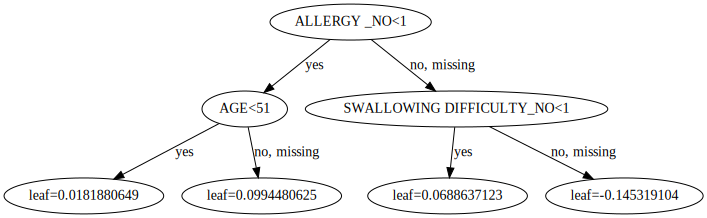

In [95]:
optimized_model.fit(X_train, y_train)

# Plot the final boosting tree of the optimized model
to_graphviz(optimized_model, yes_color='#0', no_color='#0')

In [93]:
cm = confusion_matrix(y_test, _pred_xgb)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 1  1]
 [ 1 59]]
